<a href="https://colab.research.google.com/github/NimaZah/Cry/blob/main/Infant_Cry.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Libraries, modules, dependencies

In [ ]:
import glob
import shutil
from pathlib import Path
from sys import argv
from scipy import signal
from scipy.io import wavfile
import numpy as np
import matplotlib.pyplot as plt
import os
# fastai library
!pip install fastbook==0.0.17
!pip install -Uqq fastbook
import fastbook
from fastbook import *
fastbook.setup_book()
from fastai.vision import *
from fastai.metrics import error_rate
import warnings
warnings.filterwarnings("ignore")

# Standardizing the directory

In [ ]:
# create a directory
path=Path('Audio/')
path.mkdir(parents=True, exist_ok=True)

In [ ]:
# Download the file from GitHub, unzip it, delete the original zip file.
os.chdir('Audio')
!wget https://github.com/gveres/donateacry-corpus/archive/master.zip
!unzip master.zip
!rm master.zip

In [ ]:
# Keep only the folder with cleaned data
os.chdir('donateacry-corpus-master')
!rm -r donateacry-android-upload-bucket
!rm -r donateacry-ios-upload-bucket
!rm -r README.md
os.chdir('donateacry_corpus_cleaned_and_updated_data') 
!rm -r README.md
!mv * ../../
os.chdir('../../')
!rm -r donateacry-corpus-master

In [ ]:
!mkdir /content/Spectrogram
!mkdir /content/Spectrogram/belly_pain_img
!mkdir /content/Spectrogram/burping_img
!mkdir /content/Spectrogram/discomfort_img
!mkdir /content/Spectrogram/hungry_img
!mkdir /content/Spectrogram/tired_img

!cp /content/Audio/belly_pain/* /content/Spectrogram/belly_pain_img
!cp /content/Audio/burping/* /content/Spectrogram/burping_img
!cp /content/Audio/discomfort/* /content/Spectrogram/discomfort_img
!cp /content/Audio/tired/* /content/Spectrogram/tired_img
!cp /content/Audio/hungry/* /content/Spectrogram/hungry_img

Creating the spectogram
-------------------

In [ ]:
def wav2img(wav_path, targetdir='', figsize=(4,4)):
    fig = plt.figure(figsize=figsize)
    sample_rate, samples = wavfile.read(wav_path)
    frequencies, times, spectrogram = signal.spectrogram(samples, sample_rate)
    plt.pcolormesh(np.log(spectrogram))
    plt.imshow(spectrogram)
    plt.axis('off')
    plt.ylim(ymax=40)
    plt.xlim(xmax=40)
    plt.savefig(targetdir + wav_path.split('/')[-1].split('.wav')[0] + '.png', dpi=100, frameon='false')
    plt.close()

In [ ]:
for i in os.listdir('/content/Spectrogram/belly_pain_img'):
    wav2img('/content/Spectrogram/belly_pain_img/' + i, '/content/Spectrogram/belly_pain_img/')
    os.remove('/content/Spectrogram/belly_pain_img/' + i)

for i in os.listdir('/content/Spectrogram/burping_img'):
    wav2img('/content/Spectrogram/burping_img/' + i, '/content/Spectrogram/burping_img/')
    os.remove('/content/Spectrogram/burping_img/' + i)

for i in os.listdir('/content/Spectrogram/discomfort_img'):
    wav2img('/content/Spectrogram/discomfort_img/' + i, '/content/Spectrogram/discomfort_img/')
    os.remove('/content/Spectrogram/discomfort_img/' + i)

for i in os.listdir('/content/Spectrogram/hungry_img'):
    wav2img('/content/Spectrogram/hungry_img/' + i, '/content/Spectrogram/hungry_img/')
    os.remove('/content/Spectrogram/hungry_img/' + i)

for i in os.listdir('/content/Spectrogram/tired_img'):
    wav2img('/content/Spectrogram/tired_img/' + i, '/content/Spectrogram/tired_img/')
    os.remove('/content/Spectrogram/tired_img/' + i)

In [ ]:
!zip -r Spectrogram.zip Spectrogram
from google.colab import files
files.download('Spectrogram.zip')

# Creating Dataset on Kaggle

In [ ]:
!pip install kaggle
!mkdir ~/.kaggle
!touch ~/.kaggle/kaggle.json
api_token = {"username":"----","key":"----"}
import json

In [ ]:
with open('/root/.kaggle/kaggle.json', 'w') as file:
  json.dump(api_token, file)
!chmod 600 ~/.kaggle/kaggle.json
!kaggle datasets download -d nimaznzn/cy4582

!unzip -q cy4582.zip
!rm -r cy4582.zip

In [ ]:
path = Path("/content/Spectrogram")
path.ls()

(#5) [Path('/content/Spectrogram/hungry_img'),Path('/content/Spectrogram/burping_img'),Path('/content/Spectrogram/discomfort_img'),Path('/content/Spectrogram/belly_pain_img'),Path('/content/Spectrogram/tired_img')]

# FastAI: Multi-class classification

In [ ]:
dls = ImageDataLoaders.from_folder(path, train=".", valid_pct=0.2,
                                   item_tfms=Resize(224),
                                   bs=64, num_workers=0)

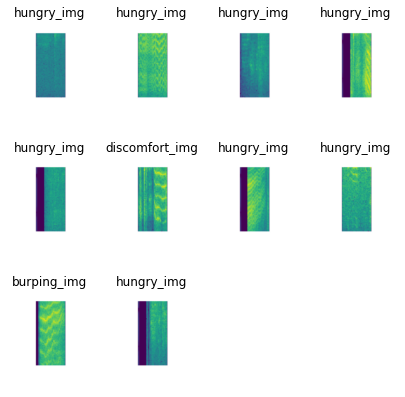

In [ ]:
# dls.train.show_batch(max_n=4, nrows=1)
dls.show_batch(max_n=10, figsize=(7,7))

In [ ]:
learn = cnn_learner(dls, resnet50, metrics=accuracy)

Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth


  0%|          | 0.00/97.8M [00:00<?, ?B/s]

In [ ]:
import time

t0 = time.time()
learn.fine_tune(20)
t1 = time.time()
print("time taken to fit the model: {}".format(t1 - t0))

epoch,train_loss,valid_loss,accuracy,time
0,2.788719,0.934043,0.758242,00:11


epoch,train_loss,valid_loss,accuracy,time
0,2.317105,1.456234,0.395604,00:13
1,2.295368,2.072333,0.142857,00:13
2,2.214367,2.178732,0.252747,00:13
3,2.100833,1.782169,0.329670,00:13
4,2.016281,2.460999,0.252747,00:13
5,1.903281,2.201181,0.340659,00:13
6,1.813370,3.699100,0.208791,00:13
7,1.658279,1.946582,0.626374,00:13
8,1.506124,2.126191,0.439560,00:13
9,1.335211,2.496877,0.450549,00:13


time taken to fit the model: 289.18694496154785


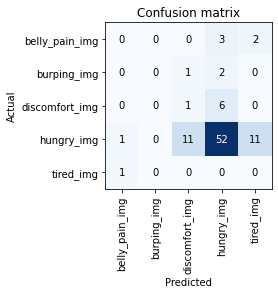

In [ ]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

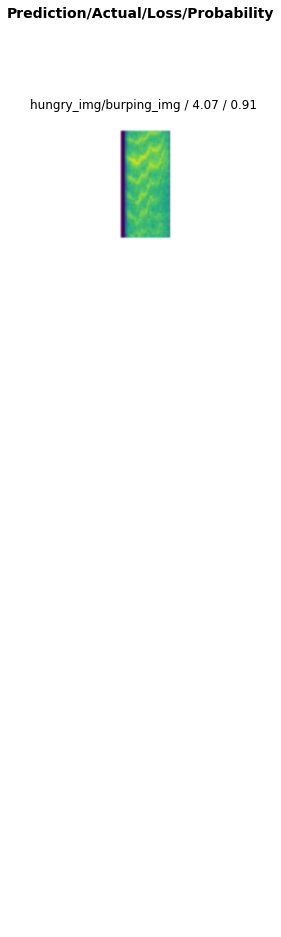

In [ ]:
interp.plot_top_losses(1, nrows=5)

# FasitAI: Binary classification

In [ ]:
!mkdir /content/CryData
!mkdir /content/CryData/hungray_img
!mkdir /content/CryData/not_hungray_img
!cp /content/Spectrogram/belly_pain_img/* /content/CryData/not_hungray_img
!cp /content/Spectrogram/burping_img/* /content/CryData/not_hungray_img
!cp /content/Spectrogram/tired_img/* /content/CryData/not_hungray_img
!cp /content/Spectrogram/discomfort_img/* /content/CryData/not_hungray_img
!cp /content/Spectrogram/hungry_img/* /content/CryData/hungray_img

In [ ]:
path = Path("/content/CryData")
path.ls()
folders = ["hungray_img", "not_hungray_img"]

In [ ]:
dls = ImageDataLoaders.from_folder(
    path, train=".", valid_pct=0.2, item_tfms=Resize(224), bs=64, num_workers=0
)

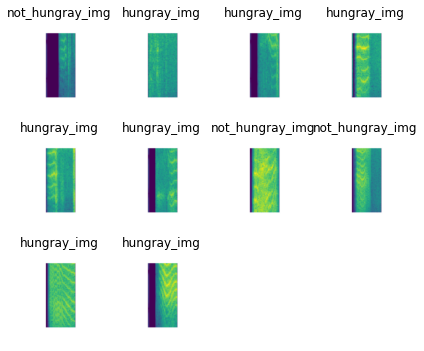

In [ ]:
dls.show_batch(max_n=10, figsize=(7,6))

In [ ]:
learn2 = cnn_learner(dls, resnet50, metrics=accuracy)

In [ ]:
import time

t0 = time.time()
learn2.fine_tune(20)
t1 = time.time()
print("time taken to fit the model: {}".format(t1 - t0))

epoch,train_loss,valid_loss,accuracy,time
0,1.376001,0.556140,0.813187,00:11


epoch,train_loss,valid_loss,accuracy,time
0,1.044120,0.918371,0.395604,00:13
1,0.959045,1.322850,0.263736,00:14
2,0.849542,1.463025,0.307692,00:13
3,0.774169,1.190161,0.483516,00:13
4,0.708007,1.815308,0.384615,00:13
5,0.661052,2.122127,0.450549,00:13
6,0.618278,1.374297,0.560440,00:13
7,0.569045,1.358851,0.604396,00:13
8,0.510287,2.523032,0.560440,00:13
9,0.467162,2.181921,0.439560,00:13


time taken to fit the model: 287.25684452056885


In [ ]:
# save the model
learn.save('/content/model')

Path('/content/model.pth')

In [ ]:
# load the model
learn.load('/content/model')

In [ ]:
learn.unfreeze()
learn.fit_one_cycle(1)

epoch,train_loss,valid_loss,accuracy,time
0,0.961008,4.858002,0.824176,00:07


SuggestedLRs(valley=0.010964781977236271)

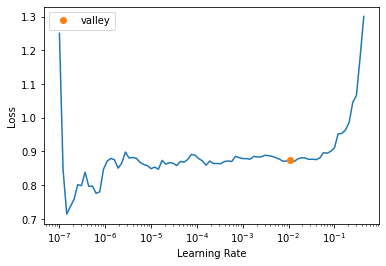

In [ ]:
learn.lr_find()

In [ ]:
learn.unfreeze()
learn.load("/content/model")

In [ ]:
learn.fit_one_cycle(10, 10e-2)

epoch,train_loss,valid_loss,accuracy,time
0,2.463444,264813.500000,0.824176,00:06
1,2.100056,1363969.625000,0.824176,00:06
2,1.916312,143944.406250,0.824176,00:06
3,1.913904,5146.246582,0.824176,00:06
4,1.697283,1421.013062,0.824176,00:06
5,1.565532,101.140015,0.406593,00:06
6,1.457475,34.439838,0.362637,00:06
7,1.357030,9.988472,0.824176,00:06
8,1.268803,3.776850,0.824176,00:06
9,1.215608,2.276840,0.824176,00:06


In [ ]:
learn.save("/content/model_final")

Path('/content/model_final.pth')

Keras Experiment (binary classification)
----------------

In [ ]:
import tensorflow as tf
from tensorflow import keras
from keras.callbacks import EarlyStopping
from keras import layers

print(tf.__version__)
print(keras.__version__)

2.8.0
2.8.0


In [ ]:
path.ls()
folders = ["hungray_img", "not_hungray_img"]

In [ ]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    path,
    validation_split=0.2,
    subset="training",
    seed=123,
    image_size=(224, 224),
    batch_size=64,
)

Found 457 files belonging to 2 classes.
Using 366 files for training.


In [ ]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    path,
    validation_split=0.2,
    subset="validation",
    seed=123,
    image_size=(224, 224),
    batch_size=64,
)

Found 457 files belonging to 2 classes.
Using 91 files for validation.


In [ ]:
model = keras.Sequential(
    [
        layers.experimental.preprocessing.Rescaling(1.0 / 255),
        layers.Conv2D(16, 3, padding="same", activation="relu"),
        layers.MaxPooling2D(),
        layers.Conv2D(32, 3, padding="same", activation="relu"),
        layers.MaxPooling2D(),
        layers.Conv2D(64, 3, padding="same", activation="relu"),
        layers.MaxPooling2D(),
        layers.Dropout(0.2),
        layers.Flatten(),
        layers.Dense(128, activation="relu"),
        layers.Dense(1),
    ]
)

In [ ]:
model.compile(
    optimizer="adam",
    loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
    metrics=["accuracy"],
)

early_stopping = EarlyStopping(monitor="val_loss", patience=10)

model.fit(train_ds, validation_data=val_ds, epochs=10, callbacks=[early_stopping])

Epoch 1/10
6/6 [==============================] - 3s 232ms/step - loss: 0.4121 - accuracy: 0.8361 - val_loss: 0.4320 - val_accuracy: 0.8352
Epoch 2/10
6/6 [==============================] - 2s 207ms/step - loss: 0.3888 - accuracy: 0.8361 - val_loss: 0.4364 - val_accuracy: 0.8352
Epoch 3/10
6/6 [==============================] - 2s 181ms/step - loss: 0.3881 - accuracy: 0.8361 - val_loss: 0.4387 - val_accuracy: 0.8352
Epoch 4/10
6/6 [==============================] - 2s 185ms/step - loss: 0.3912 - accuracy: 0.8361 - val_loss: 0.4429 - val_accuracy: 0.8352
Epoch 5/10
6/6 [==============================] - 2s 183ms/step - loss: 0.4031 - accuracy: 0.8361 - val_loss: 0.4591 - val_accuracy: 0.8352
Epoch 6/10
6/6 [==============================] - 2s 183ms/step - loss: 0.3927 - accuracy: 0.8361 - val_loss: 0.4364 - val_accuracy: 0.8352
Epoch 7/10
6/6 [==============================] - 2s 185ms/step - loss: 0.3840 - accuracy: 0.8361 - val_loss: 0.4465 - val_accuracy: 0.8352
Epoch 8/10
6/6 [====

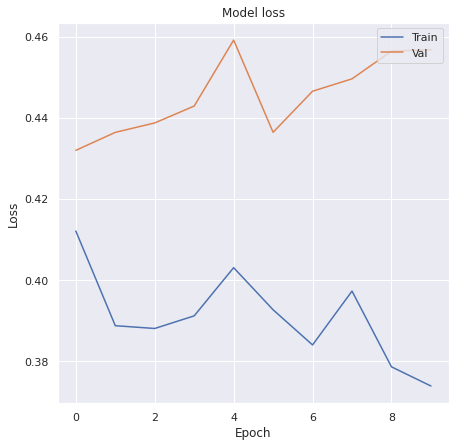

In [ ]:
# Visualize the loss function
plt.figure(figsize=(7, 7))
plt.plot(model.history.history["loss"])
plt.plot(model.history.history["val_loss"])
plt.title("Model loss")
plt.ylabel("Loss")
plt.xlabel("Epoch")
plt.legend(["Train", "Val"], loc="upper right")
plt.show()

In [ ]:
# Save the model
model.save('model.h5')